# Evaluate computational performance of different score implementations
## Compare CosineGreedy, CosineHungarian, and Spec2Vec
Evalute the influence on the compuation time of
- number of peaks 
- peak matching tolerance
- number of scores computed simultaneously

### Data
- Use synthetic, i.e. randomly generated spectra to have full control over the number of peaks etc.

In [1]:
import os
import sys

#path_data = os.path.join(os.path.dirname(os.getcwd()), 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
path_root = os.path.join(os.path.dirname(os.getcwd()))
sys.path.insert(0, path_root)

### Creat random spectra

In [15]:
import time
import numpy as np
from matchms import Spectrum, Scores

n_peaks = 5000
n_spectrums = 500

spectrums = []
for i in range(n_spectrums):
    spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                              intensities=np.random.rand((n_peaks)),
                              metadata={"precursor_mz": 500.0}))

### Post-process spectra
+ Normalize spectrum
+ Remove peaks outside m/z ratios between 0 and 1000.0
+ Discard spectra with less then 10 remaining peaks (to make it consistent with later spec2vec analysis)
+ Remove peaks with relative intensity lower than 0.01

In [3]:
from matchms.filtering import reduce_to_number_of_peaks

In [4]:
def spectra_process(s, max_peaks):
    #s = select_by_relative_intensity(s, intensity_from=0.005, intensity_to=1.0)
    s = reduce_to_number_of_peaks(s, n_max=max_peaks)
    return s

In [5]:
print("Remaining number of spectra:", len(spectrums))

Remaining number of spectra: 100


In [6]:
spectrums[0].peaks.mz.shape

(5000,)

# CosineGreedy evaluation

In [359]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix


n_peaks = 5000
n_spectrums = 50
n_iterations = 10
max_number_peaks = [20, 50, 100, 200, 500, 750, 1000, 1500, 2000]
    
iterations = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    spectrums = []
    np.random.seed(i)
    for i in range(n_spectrums):
        spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                  intensities=np.random.rand((n_peaks)),
                                  metadata={"precursor_mz": 500.0}))

    for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        # Define similarity measure
        similarity_measure = CosineGreedy(tolerance=0.005)

        #filename = os.path.join(path_data, f"similarities_mod_cosine_tol0005_201128_max{max_peaks}.npy")

        #print("start calculating...")
        tstart = time.time()
        #similarities, num_matches = all_vs_all_similarity_matrix(spectrums_processed, similarity_measure,
        #                                                         filename, safety_points=1)
        similarity_matrix = similarity_measure.matrix(spectrums_processed, spectrums_processed, is_symmetric=False)

        tend = time.time()
        print(f"Run at max_peaks={max_peaks} took {tend - tstart:.2f} s.")
        calculation_times.append(tend - tstart)

    iterations.append(calculation_times)

Iteration 1 -----------------
Run at max_peaks=20 took 0.34 s.
Run at max_peaks=50 took 0.30 s.
Run at max_peaks=100 took 0.34 s.
Run at max_peaks=200 took 0.36 s.
Run at max_peaks=500 took 0.58 s.
Run at max_peaks=750 took 0.56 s.
Run at max_peaks=1000 took 0.81 s.
Run at max_peaks=1500 took 0.92 s.
Run at max_peaks=2000 took 1.18 s.
Iteration 2 -----------------
Run at max_peaks=20 took 0.28 s.
Run at max_peaks=50 took 0.28 s.
Run at max_peaks=100 took 0.39 s.
Run at max_peaks=200 took 0.40 s.
Run at max_peaks=500 took 0.66 s.
Run at max_peaks=750 took 0.75 s.
Run at max_peaks=1000 took 0.81 s.
Run at max_peaks=1500 took 0.94 s.
Run at max_peaks=2000 took 1.21 s.
Iteration 3 -----------------
Run at max_peaks=20 took 0.27 s.
Run at max_peaks=50 took 0.25 s.
Run at max_peaks=100 took 0.27 s.
Run at max_peaks=200 took 0.33 s.
Run at max_peaks=500 took 0.61 s.
Run at max_peaks=750 took 0.57 s.
Run at max_peaks=1000 took 0.86 s.
Run at max_peaks=1500 took 1.17 s.
Run at max_peaks=2000 to

In [360]:
n_pairs = n_spectrums ** 2 # /2 + n_spectrums/2
n_pairs

2500

In [361]:
iterations_scaled = np.array(iterations)/n_pairs*1000
iterations_scaled.mean(axis=0), iterations_scaled.std(axis=0)

(array([0.13119978, 0.12632416, 0.13888141, 0.17810354, 0.24987056,
        0.27266008, 0.33001449, 0.46225057, 0.57799467]),
 array([0.0220667 , 0.02661697, 0.02321446, 0.03363457, 0.02700051,
        0.03973137, 0.02196478, 0.06877682, 0.09792511]))

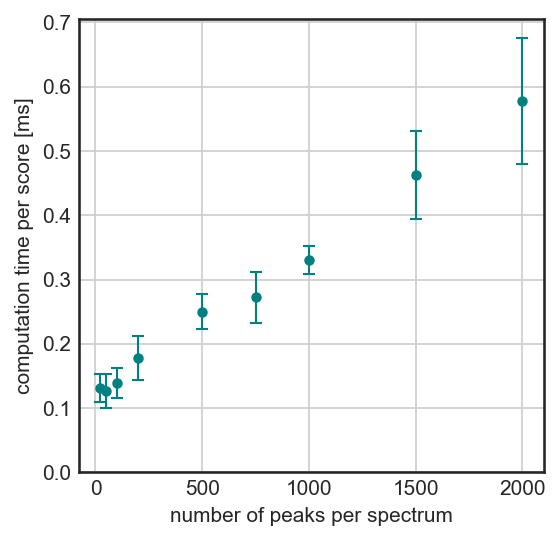

In [364]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4, 4), dpi=150)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled.mean(axis=0),
             yerr=1 * iterations_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
plt.savefig("cosine_performance_vs_peaks_synthetic_201202.svg")

In [274]:
iterations_scaled = np.array(iterations)/n_pairs*1000
iterations_scaled.mean(axis=0), iterations_scaled.std(axis=0)

(array([0.14038091, 0.16230187, 0.17475054, 0.22260845, 0.34952219,
        0.4602221 , 0.57049336, 0.85017014, 1.14403367]),
 array([0.04345555, 0.05321845, 0.05270952, 0.06380631, 0.09834669,
        0.1232082 , 0.13920641, 0.37686324, 0.56928509]))

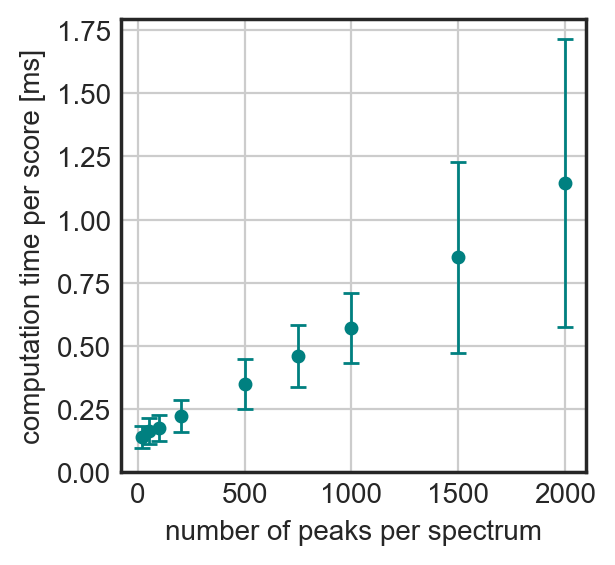

In [275]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled.mean(axis=0),
             yerr=1 * iterations_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
plt.savefig("cosine_performance_vs_peaks_synthetic_201201_2.svg")

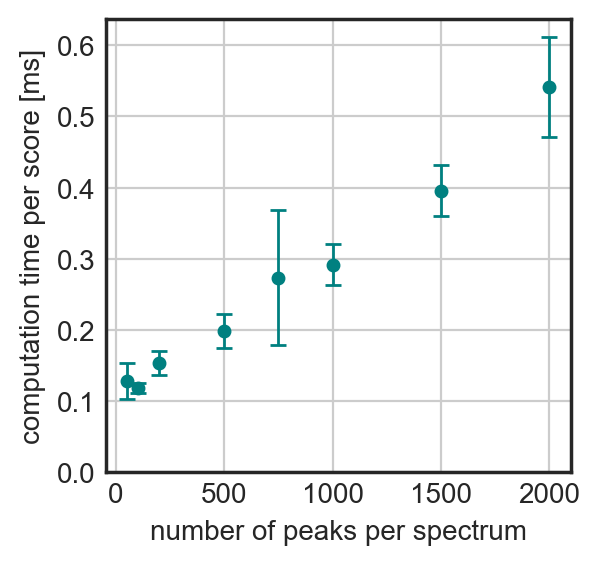

In [266]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled.mean(axis=0),
             yerr=1 * iterations_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
plt.savefig("cosine_performance_vs_peaks_synthetic_201201_2.svg")

# Compare CosineGreedy vs number of spectra pairs

In [367]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix

n_peaks = 5000
n_spectrums = [1, 3, 7, 10, 30, 70, 100, 300, 700, 1000]
n_iterations = 2
#max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
max_peaks = 200
    
iterations = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    for num in n_spectrums:
        spectrums = []
        np.random.seed(i)
        for j in range(num):
            spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                      intensities=np.random.rand((n_peaks)),
                                      metadata={"precursor_mz": 500.0}))

        #for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        # Define similarity measure
        similarity_measure = CosineGreedy(tolerance=0.005)

        #print("start calculating...")
        tstart = time.time()
        #similarities, num_matches = all_vs_all_similarity_matrix(spectrums_processed, similarity_measure,
        #                                                         filename, safety_points=1)
        if num == 1:
            similarity_matrix = similarity_measure.pair(spectrums_processed[0], spectrums_processed[0])
        else:
            similarity_matrix = similarity_measure.matrix(spectrums_processed, spectrums_processed, is_symmetric=False)

        tend = time.time()
        print(f"Calculating similarities for {num}x{num} spectra took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations.append(calculation_times)

Iteration 1 -----------------
Calculating similarities for 1x1 spectra took 0.0 s.
Calculating similarities for 3x3 spectra took 0.0 s.
Calculating similarities for 7x7 spectra took 0.0 s.
Calculating similarities for 10x10 spectra took 0.0 s.
Calculating similarities for 30x30 spectra took 0.2 s.
Calculating similarities for 70x70 spectra took 0.9 s.
Calculating similarities for 100x100 spectra took 1.7 s.
Calculating similarities for 300x300 spectra took 12.1 s.
Calculating similarities for 700x700 spectra took 86.9 s.
Calculating similarities for 1000x1000 spectra took 153.5 s.
Iteration 2 -----------------
Calculating similarities for 1x1 spectra took 0.1 s.
Calculating similarities for 3x3 spectra took 0.0 s.
Calculating similarities for 7x7 spectra took 0.0 s.
Calculating similarities for 10x10 spectra took 0.0 s.
Calculating similarities for 30x30 spectra took 0.2 s.
Calculating similarities for 70x70 spectra took 1.0 s.
Calculating similarities for 100x100 spectra took 2.0 s.
C

In [368]:
iterations_scaled = 1000 * np.array(iterations)/(np.array(n_spectrums)**2)
iterations_scaled.mean(axis=0), iterations_scaled.std(axis=0)

(array([57.28828907,  0.27596951,  0.20248793,  0.18581986,  0.19428598,
         0.18954318,  0.18094058,  0.16347042,  0.16355402,  0.15917364]),
 array([2.15760469e+01, 5.55117925e-02, 5.10896955e-05, 7.61389732e-03,
        2.56053607e-02, 1.39181225e-02, 1.47312164e-02, 2.90933437e-02,
        1.38784674e-02, 5.65018666e-03]))

In [177]:
iterations_scaled = 1000 * np.array(iterations)/(np.array(n_spectrums)**2)
iterations_scaled.mean(axis=0), iterations_scaled.std(axis=0)

(array([54.70573902,  0.4363007 ,  0.25303121,  0.22327209,  0.14885587,
         0.12717743,  0.12319627,  0.10637766,  0.11322641,  0.10962962]),
 array([1.81661870e+01, 1.34801030e-01, 5.94348554e-02, 7.16238081e-02,
        3.17241610e-02, 1.90806030e-02, 1.08578138e-02, 7.22616381e-03,
        1.16086183e-02, 8.62386162e-03]))

In [375]:
scores_times = []
for _ in range(100):
    tstart = time.time()
    for _ in range(10):
        score = similarity_measure.matrix([spectrums_processed[100]], [spectrums_processed[12]])
    tend = time.time()
    scores_times.append(tend-tstart)
    
(tend-tstart)/10 * 1000

0.1984119415283203

In [376]:
(np.array(scores_times)/10 * 1000).std(), (np.array(scores_times)/10 * 1000).mean()

(0.0627992434215717, 0.18302202224731445)

In [377]:
means = iterations_scaled.mean(axis=0)
means[0] = 0.18302202224731445
stds = iterations_scaled.std(axis=0)
stds[0] = 0.0627992434215717

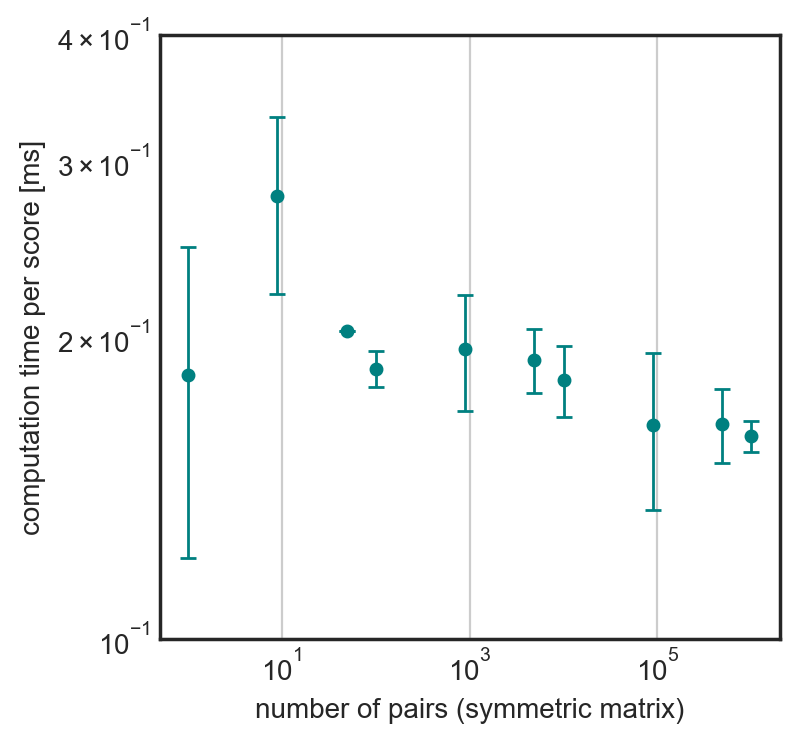

In [382]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4, 4), dpi=200)
plt.style.use('seaborn-white')
labels = np.array(n_spectrums)**2
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(labels, means,
             yerr=1 * stds, fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of pairs (symmetric matrix)')
plt.yscale("log")
plt.xscale("log")
plt.ylim((0.1, 0.4))
plt.grid(True)
plt.savefig("cosine_performance_vs_num_pairs_synthetic_201202.svg")

# Compare CosineGreedy vs. tolerance

In [354]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix


n_peaks = 5000
n_spectrums = 20
n_iterations = 10
#max_number_peaks = [20, 50, 100, 200, 500, 750, 1000, 1500, 2000]
max_peaks = 500
tolerances = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.7, 1.0]

    
iterations_tol = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    spectrums = []
    np.random.seed(i)
    for i in range(n_spectrums):
        spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                  intensities=np.random.rand((n_peaks)),
                                  metadata={"precursor_mz": 500.0}))

    for tolerance in tolerances:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        # Define similarity measure
        similarity_measure = CosineGreedy(tolerance=tolerance)

        #filename = os.path.join(path_data, f"similarities_mod_cosine_tol0005_201128_max{max_peaks}.npy")

        #print("start calculating...")
        tstart = time.time()
        #similarities, num_matches = all_vs_all_similarity_matrix(spectrums_processed, similarity_measure,
        #                                                         filename, safety_points=1)
        similarity_matrix = similarity_measure.matrix(spectrums_processed, spectrums_processed, is_symmetric=False)

        tend = time.time()
        print(f"Run at tolerance={tolerance} took {tend - tstart:.2f} s.")
        calculation_times.append(tend - tstart)

    iterations_tol.append(calculation_times)

Iteration 1 -----------------
Run at tolerance=0.001 took 0.10 s.
Run at tolerance=0.005 took 0.09 s.
Run at tolerance=0.01 took 0.11 s.
Run at tolerance=0.05 took 0.17 s.
Run at tolerance=0.1 took 0.26 s.
Run at tolerance=0.2 took 0.41 s.
Run at tolerance=0.4 took 0.61 s.
Run at tolerance=0.7 took 0.72 s.
Run at tolerance=1.0 took 0.89 s.
Iteration 2 -----------------
Run at tolerance=0.001 took 0.07 s.
Run at tolerance=0.005 took 0.08 s.
Run at tolerance=0.01 took 0.13 s.
Run at tolerance=0.05 took 0.12 s.
Run at tolerance=0.1 took 0.16 s.
Run at tolerance=0.2 took 0.21 s.
Run at tolerance=0.4 took 0.31 s.
Run at tolerance=0.7 took 0.51 s.
Run at tolerance=1.0 took 0.74 s.
Iteration 3 -----------------
Run at tolerance=0.001 took 0.07 s.
Run at tolerance=0.005 took 0.08 s.
Run at tolerance=0.01 took 0.09 s.
Run at tolerance=0.05 took 0.11 s.
Run at tolerance=0.1 took 0.15 s.
Run at tolerance=0.2 took 0.23 s.
Run at tolerance=0.4 took 0.34 s.
Run at tolerance=0.7 took 0.51 s.
Run at t

In [356]:
n_pairs = n_spectrums ** 2 # /2 + n_spectrums/2
n_pairs

400

In [357]:
iterations_tol_scaled = 1000 * np.array(iterations_tol)/(np.array(n_spectrums)**2)
iterations_tol_scaled.mean(axis=0), iterations_tol_scaled.std(axis=0)

(array([0.24574   , 0.27044672, 0.27394181, 0.35341161, 0.43484449,
        0.63153052, 1.00016469, 1.54057735, 2.08468908]),
 array([0.10726928, 0.05682202, 0.04620006, 0.05084411, 0.08055527,
        0.14203593, 0.25369896, 0.2037653 , 0.34095334]))

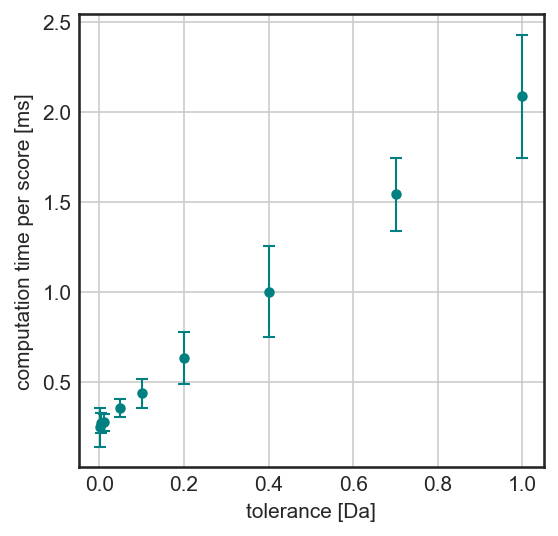

In [358]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4,4), dpi=150)
plt.style.use('seaborn-white')
labels = tolerances
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(labels, iterations_tol_scaled.mean(axis=0),
             yerr=1 * iterations_tol_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('tolerance [Da]')
#plt.yscale("log")
#plt.xscale("log")
#plt.ylim(0)
plt.grid(True)
plt.savefig("cosine_performance_vs_tolerance_synthetic_201201.svg")

# CosineHungarian evaluation

In [58]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix


n_peaks = 5000
n_spectrums = 50
n_iterations = 10
max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500]#, 2000]
    
iterations_hung = []
for i in range(n_iterations):
    calculation_times_hung = []

    print(f"Iteration {i + 1} -----------------")
    spectrums = []
    np.random.seed(i)
    for i in range(n_spectrums):
        spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                  intensities=np.random.rand((n_peaks)),
                                  metadata={"precursor_mz": 500.0}))

    for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        # Define similarity measure
        similarity_measure = CosineHungarian(tolerance=0.005)

        #filename = os.path.join(path_data, f"similarities_mod_cosine_tol0005_201128_max{max_peaks}.npy")

        #print("start calculating...")
        tstart = time.time()
        #similarities, num_matches = all_vs_all_similarity_matrix(spectrums_processed, similarity_measure,
        #                                                         filename, safety_points=1)
        similarity_matrix = similarity_measure.matrix(spectrums_processed, spectrums_processed, is_symmetric=True)

        tend = time.time()
        print(f"Run at max_peaks={max_peaks} took {tend - tstart:.1f} s.")
        calculation_times_hung.append(tend - tstart)

    iterations_hung.append(calculation_times_hung)

Iteration 1 -----------------
Run at max_peaks=50 took 0.3 s.
Run at max_peaks=100 took 0.3 s.
Run at max_peaks=200 took 0.7 s.
Run at max_peaks=500 took 3.4 s.
Run at max_peaks=750 took 10.5 s.
Run at max_peaks=1000 took 25.2 s.
Run at max_peaks=1500 took 144.3 s.
Iteration 2 -----------------
Run at max_peaks=50 took 0.3 s.
Run at max_peaks=100 took 0.4 s.
Run at max_peaks=200 took 0.9 s.
Run at max_peaks=500 took 4.3 s.
Run at max_peaks=750 took 12.8 s.
Run at max_peaks=1000 took 28.8 s.
Run at max_peaks=1500 took 147.6 s.
Iteration 3 -----------------
Run at max_peaks=50 took 0.3 s.
Run at max_peaks=100 took 0.3 s.
Run at max_peaks=200 took 0.6 s.
Run at max_peaks=500 took 3.4 s.
Run at max_peaks=750 took 11.9 s.
Run at max_peaks=1000 took 31.1 s.
Run at max_peaks=1500 took 136.3 s.
Iteration 4 -----------------
Run at max_peaks=50 took 0.2 s.
Run at max_peaks=100 took 0.3 s.
Run at max_peaks=200 took 0.7 s.
Run at max_peaks=500 took 3.7 s.
Run at max_peaks=750 took 12.1 s.
Run at 

In [59]:
# number of pairs that were computed (is_symmetric=True)
n_pairs = n_spectrums ** 2 /2 + n_spectrums/2
n_pairs

1275.0

In [60]:
np.array(iterations_hung).shape

(10, 7)

In [61]:
iterations_scaled_hung = np.array(iterations_hung)/n_pairs*1000
iterations_scaled_hung.mean(axis=0), iterations_scaled_hung.std(axis=0)

(array([  0.18988385,   0.24309714,   0.48973762,   2.50204909,
          8.7674122 ,  23.27865797, 109.71013544]),
 array([0.03649392, 0.03470324, 0.08193051, 0.40755989, 0.75272009,
        2.29233494, 5.09749199]))

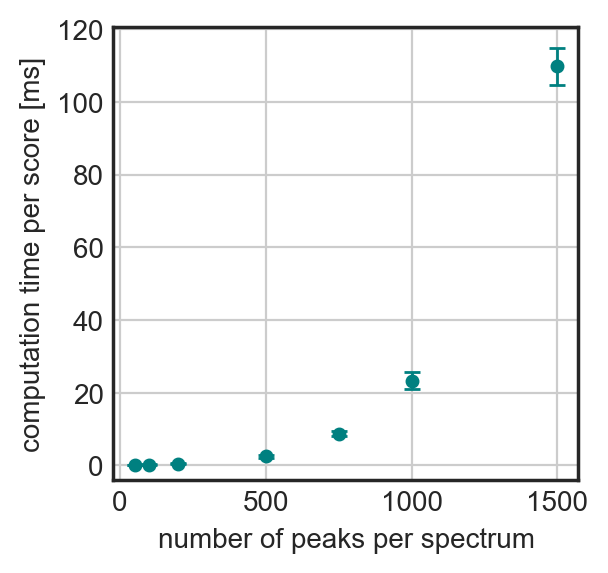

In [63]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks

plt.errorbar(labels, iterations_scaled_hung.mean(axis=0),
             yerr=1 * iterations_scaled_hung.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(-4)
plt.grid(True)
plt.savefig("cosine_performance_vs_peaks_synthetic_201201_hungarian.svg")

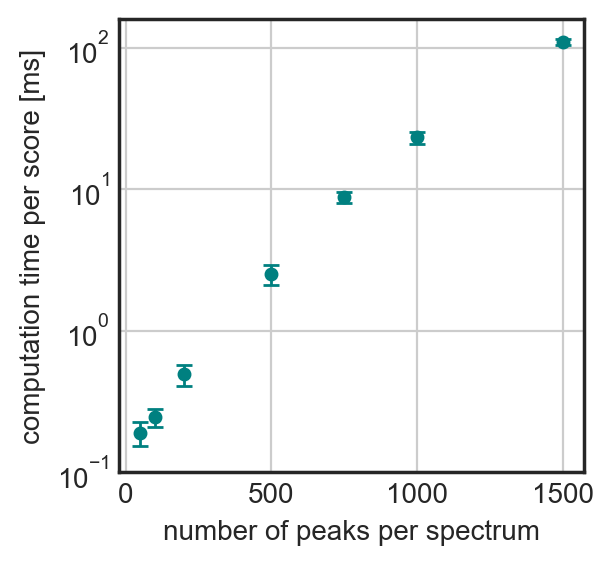

In [65]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled_hung.mean(axis=0),
             yerr=1 * iterations_scaled_hung.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.yscale("log")
plt.ylim(0.1)
plt.grid(True)
plt.savefig("cosine_performance_vs_peaks_synthetic_201201_hungarian_log.svg")

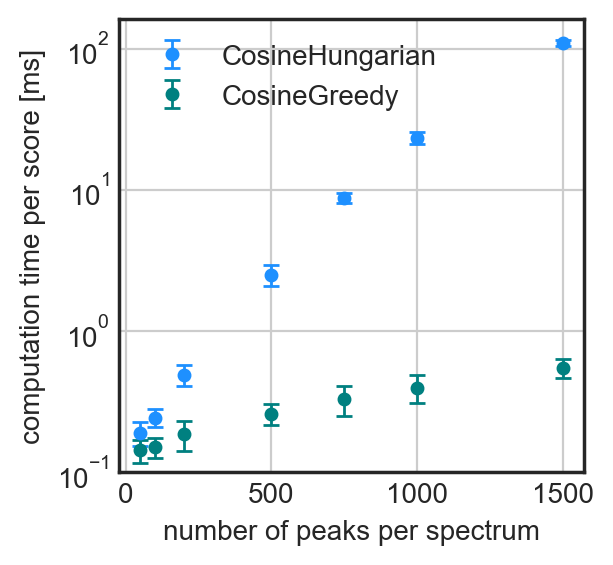

In [68]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled_hung.mean(axis=0),
             yerr=1 * iterations_scaled_hung.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="dodgerblue", ecolor="dodgerblue", label="CosineHungarian")

plt.errorbar(labels, iterations_scaled.mean(axis=0)[:-1],
             yerr=1 * iterations_scaled.std(axis=0)[:-1], fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal", label="CosineGreedy")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.yscale("log")
plt.ylim(0.1)
plt.grid(True)
plt.legend()
plt.savefig("cosine_performance_vs_peaks_synthetic_201201_hungarian_log_compare.svg")

# Spec2vec evaluation

In [70]:
import gensim

path_models = os.path.join(path_data, "trained_models")
#model_file = os.path.join(path_models, "spec2vec_UniqueInchikeys_ratio05_filtered_iter_50.model")
model_file = os.path.join(path_models, "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model")

# Load pretrained model
model = gensim.models.Word2Vec.load(model_file)

In [300]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

n_peaks = 5000
n_spectrums = 1000
n_iterations = 10
max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
    
iterations = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    spectrums = []
    np.random.seed(i)
    for i in range(n_spectrums):
        spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                  intensities=np.random.rand((n_peaks)),
                                  metadata={"precursor_mz": 500.0}))

    for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]  

        # Define similarity measure
        spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage= 20.0)

        filename = os.path.join(path_data, f"similarities_spec2vec_tol0005_201128_max{max_peaks}.npy")

        tstart = time.time()
        similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=False)

        tend = time.time()
        print(f"Run at max_peaks={max_peaks} took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations.append(calculation_times)

Iteration 1 -----------------
Run at max_peaks=50 took 1.3 s.
Run at max_peaks=100 took 2.3 s.
Run at max_peaks=200 took 3.1 s.
Run at max_peaks=500 took 11.6 s.
Run at max_peaks=750 took 16.5 s.
Run at max_peaks=1000 took 24.8 s.
Run at max_peaks=1500 took 38.7 s.
Run at max_peaks=2000 took 49.1 s.
Iteration 2 -----------------
Run at max_peaks=50 took 0.9 s.
Run at max_peaks=100 took 1.6 s.
Run at max_peaks=200 took 3.2 s.
Run at max_peaks=500 took 12.5 s.
Run at max_peaks=750 took 19.4 s.
Run at max_peaks=1000 took 29.2 s.
Run at max_peaks=1500 took 37.3 s.
Run at max_peaks=2000 took 52.0 s.
Iteration 3 -----------------
Run at max_peaks=50 took 1.0 s.
Run at max_peaks=100 took 1.6 s.
Run at max_peaks=200 took 3.7 s.
Run at max_peaks=500 took 12.6 s.
Run at max_peaks=750 took 23.8 s.
Run at max_peaks=1000 took 33.3 s.
Run at max_peaks=1500 took 44.8 s.
Run at max_peaks=2000 took 64.5 s.
Iteration 4 -----------------
Run at max_peaks=50 took 1.3 s.
Run at max_peaks=100 took 1.8 s.
Ru

In [320]:
n_pairs = n_spectrums ** 2 # /2 + n_spectrums/2
n_pairs

1000000

In [321]:
iterations_scaled = np.array(iterations)/n_pairs*1000
iterations_scaled.mean(axis=0), iterations_scaled.std(axis=0)

(array([0.00114199, 0.00195449, 0.00375277, 0.01256759, 0.02032097,
        0.03042901, 0.04094044, 0.05768198]),
 array([0.00018426, 0.00032829, 0.00068721, 0.00134701, 0.00248264,
        0.00532429, 0.00377534, 0.00728408]))

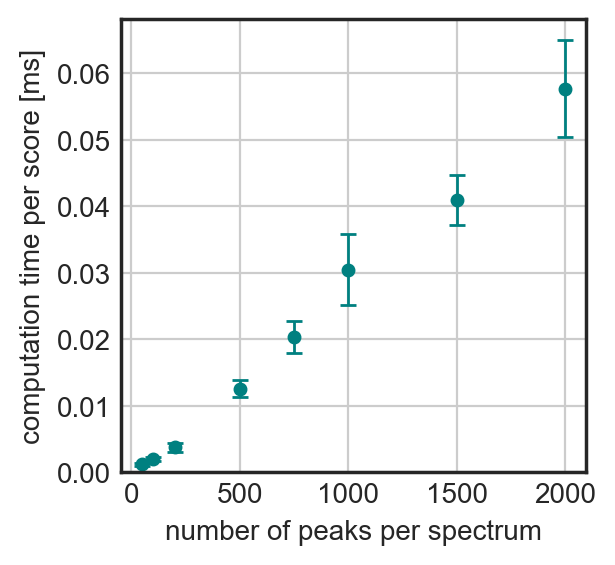

In [322]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled.mean(axis=0),
             yerr=1 * iterations_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201_1000x1000.svg")

In [308]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

n_peaks = 5000
n_spectrums = 1
n_iterations = 10
max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
    
iterations2 = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    spectrums = []
    np.random.seed(i)
    for _ in range(n_spectrums):
        spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                  intensities=np.random.rand((n_peaks)),
                                  metadata={"precursor_mz": 500.0}))

    for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]  

        # Define similarity measure
        spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage= 20.0)

        filename = os.path.join(path_data, f"similarities_spec2vec_tol0005_201128_max{max_peaks}.npy")

        tstart = time.time()
        similarity_matrix = spec2vec_similarity.pair(documents[0], documents[0])
        #similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)

        tend = time.time()
        print(f"Run at max_peaks={max_peaks} took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations2.append(calculation_times)

Iteration 1 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=200 took 0.0 s.
Run at max_peaks=500 took 0.0 s.
Run at max_peaks=750 took 0.0 s.
Run at max_peaks=1000 took 0.0 s.
Run at max_peaks=1500 took 0.0 s.
Run at max_peaks=2000 took 0.0 s.
Iteration 2 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=200 took 0.0 s.
Run at max_peaks=500 took 0.0 s.
Run at max_peaks=750 took 0.0 s.
Run at max_peaks=1000 took 0.0 s.
Run at max_peaks=1500 took 0.0 s.
Run at max_peaks=2000 took 0.0 s.
Iteration 3 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=200 took 0.0 s.
Run at max_peaks=500 took 0.0 s.
Run at max_peaks=750 took 0.0 s.
Run at max_peaks=1000 took 0.0 s.
Run at max_peaks=1500 took 0.0 s.
Run at max_peaks=2000 took 0.1 s.
Iteration 4 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=

In [309]:
n_pairs = n_spectrums ** 2 /2 + n_spectrums/2
n_pairs

1.0

In [310]:
iterations_scaled2 = np.array(iterations2)/n_pairs*1000
iterations_scaled2.mean(axis=0), iterations_scaled2.std(axis=0)

(array([ 1.19485855,  2.17711926,  3.428936  , 12.34300137, 21.37389183,
        28.12359333, 42.15764999, 53.56097221]),
 array([0.4530648 , 0.96829033, 0.7103772 , 2.21358595, 6.06272583,
        4.02912066, 7.11439963, 7.1911693 ]))

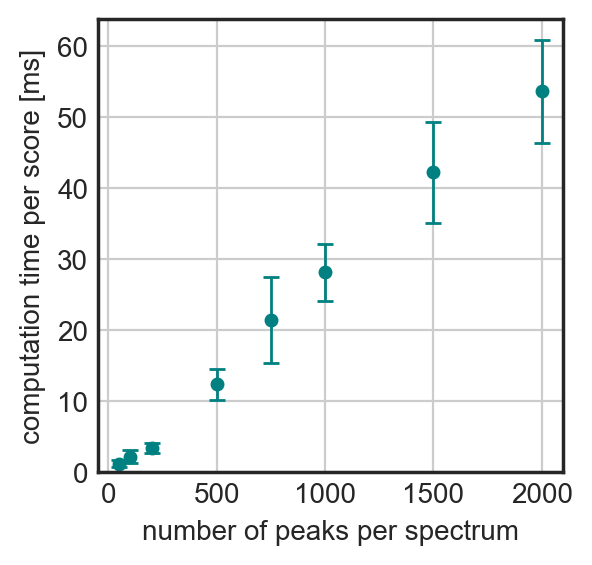

In [311]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled2.mean(axis=0),
             yerr=1 * iterations_scaled2.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201_1x1.svg")

In [317]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

n_peaks = 5000
n_spectrums = 10
n_iterations = 10
max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
    
iterations_10x10 = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    spectrums = []
    np.random.seed(i)
    for _ in range(n_spectrums):
        spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                  intensities=np.random.rand((n_peaks)),
                                  metadata={"precursor_mz": 500.0}))

    for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]  

        # Define similarity measure
        spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage= 20.0)

        filename = os.path.join(path_data, f"similarities_spec2vec_tol0005_201128_max{max_peaks}.npy")

        tstart = time.time()
        #similarity_matrix = spec2vec_similarity.pair(documents[0], documents[0])
        similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=False)

        tend = time.time()
        print(f"Run at max_peaks={max_peaks} took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations_10x10.append(calculation_times)

Iteration 1 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=200 took 0.0 s.
Run at max_peaks=500 took 0.1 s.
Run at max_peaks=750 took 0.2 s.
Run at max_peaks=1000 took 0.3 s.
Run at max_peaks=1500 took 0.4 s.
Run at max_peaks=2000 took 0.5 s.
Iteration 2 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=200 took 0.0 s.
Run at max_peaks=500 took 0.1 s.
Run at max_peaks=750 took 0.2 s.
Run at max_peaks=1000 took 0.3 s.
Run at max_peaks=1500 took 0.4 s.
Run at max_peaks=2000 took 0.5 s.
Iteration 3 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=200 took 0.0 s.
Run at max_peaks=500 took 0.1 s.
Run at max_peaks=750 took 0.2 s.
Run at max_peaks=1000 took 0.3 s.
Run at max_peaks=1500 took 0.4 s.
Run at max_peaks=2000 took 0.6 s.
Iteration 4 -----------------
Run at max_peaks=50 took 0.0 s.
Run at max_peaks=100 took 0.0 s.
Run at max_peaks=

In [323]:
n_pairs = n_spectrums ** 2 # /2 + n_spectrums/2
n_pairs

100

In [324]:
iterations_scaled_10x10 = np.array(iterations_10x10)/n_pairs*1000
iterations_scaled_10x10.mean(axis=0), iterations_scaled_10x10.std(axis=0)

(array([0.11204481, 0.18950057, 0.39137745, 1.27776694, 1.93287826,
        2.84114194, 4.21692634, 5.28782225]),
 array([0.03031416, 0.03904656, 0.07007363, 0.13702929, 0.21697733,
        0.31138051, 0.62021301, 0.5158636 ]))

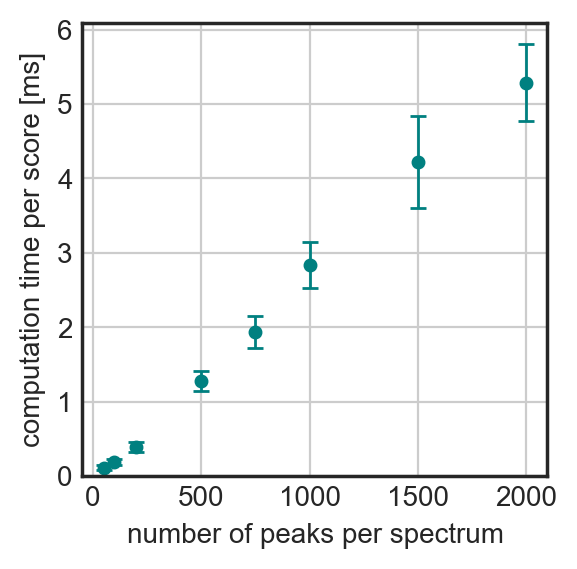

In [326]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled_10x10.mean(axis=0),
             yerr=1 * iterations_scaled_10x10.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201_10x10.svg")

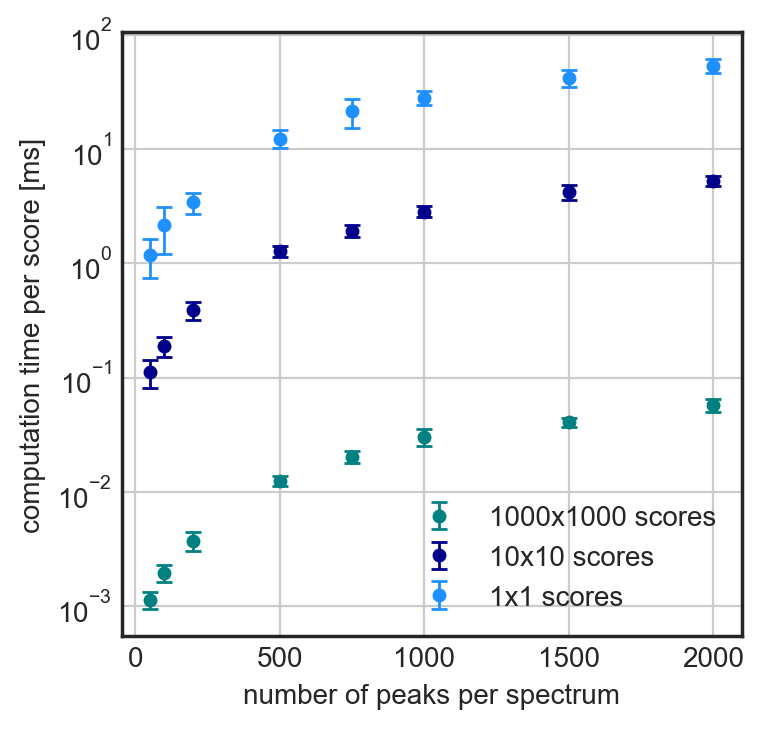

In [335]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4,4), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
plt.errorbar(labels, iterations_scaled.mean(axis=0),
             yerr=1 * iterations_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal",
             label="1000x1000 scores")

plt.errorbar(labels, iterations_scaled_10x10.mean(axis=0),
             yerr=1 * iterations_scaled_10x10.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="darkblue", ecolor="darkblue",
             label="10x10 scores")

plt.errorbar(labels, iterations_scaled2.mean(axis=0),
             yerr=1 * iterations_scaled2.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="dodgerblue", ecolor="dodgerblue",
             label="1x1 scores")

plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.yscale("log")
#plt.xscale("log")
#plt.ylim(0)
plt.grid(True)
plt.legend()
plt.savefig("spec2vec_performance_vs_matrix_size_and_peaks_synthetic_201201.svg")

In [90]:
iterations_scaled2 = np.array(iterations2)/n_pairs*1000
iterations_scaled2.mean(axis=0), iterations_scaled2.std(axis=0)

(array([ 1.24018192,  1.88536644,  3.70941162, 13.63997459, 19.29335594,
        25.48389435, 38.73419762, 50.2155304 ]),
 array([0.39998896, 0.52772753, 0.83162683, 2.06293651, 2.42613922,
        2.34734801, 4.8660387 , 4.79640431]))

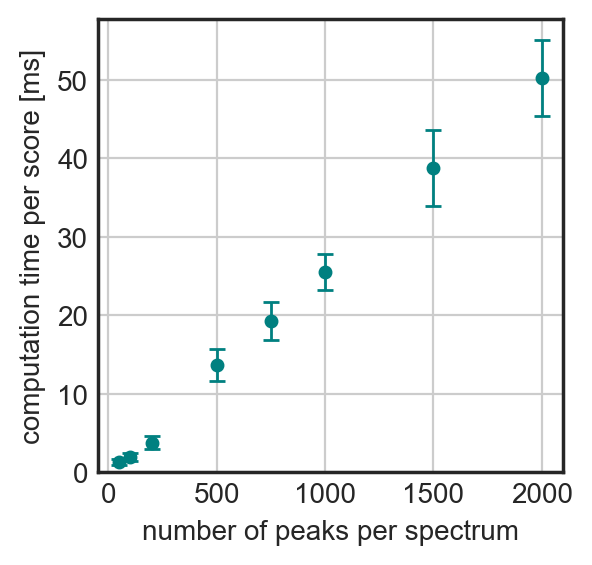

In [91]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = max_number_peaks
#plt.scatter(labels, iterations_scaled.mean(axis=0), s=25, color="red")

plt.errorbar(labels, iterations_scaled2.mean(axis=0),
             yerr=1 * iterations_scaled2.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of peaks per spectrum')
plt.ylim(0)
plt.grid(True)
#plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201.svg")

In [96]:
max(documents[0].weights)

0.9999779517807228

In [383]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

n_peaks = 5000
n_spectrums = [1, 3, 7, 10, 30, 70, 100, 300, 700, 1000]
n_iterations = 10
#max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
max_peaks = 200
    
iterations2 = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    for num in n_spectrums:
        spectrums = []
        np.random.seed(i)
        for j in range(num):
            spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                      intensities=np.random.rand((n_peaks)),
                                      metadata={"precursor_mz": 500.0}))

        #for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]  

        # Define similarity measure
        spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage= 20.0)

        #filename = os.path.join(path_data, f"similarities_spec2vec_tol0005_201128_max{max_peaks}.npy")

        tstart = time.time()
        similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=False)

        tend = time.time()
        print(f"Calculating similarities for {num}x{num} spectra took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations2.append(calculation_times)

Iteration 1 -----------------
Calculating similarities for 1x1 spectra took 0.1 s.
Calculating similarities for 3x3 spectra took 0.0 s.
Calculating similarities for 7x7 spectra took 0.0 s.
Calculating similarities for 10x10 spectra took 0.0 s.
Calculating similarities for 30x30 spectra took 0.1 s.
Calculating similarities for 70x70 spectra took 0.3 s.
Calculating similarities for 100x100 spectra took 0.4 s.
Calculating similarities for 300x300 spectra took 1.0 s.
Calculating similarities for 700x700 spectra took 2.8 s.
Calculating similarities for 1000x1000 spectra took 4.7 s.
Iteration 2 -----------------
Calculating similarities for 1x1 spectra took 0.0 s.
Calculating similarities for 3x3 spectra took 0.0 s.
Calculating similarities for 7x7 spectra took 0.0 s.
Calculating similarities for 10x10 spectra took 0.1 s.
Calculating similarities for 30x30 spectra took 0.2 s.
Calculating similarities for 70x70 spectra took 0.5 s.
Calculating similarities for 100x100 spectra took 0.7 s.
Calcu

In [404]:
import pickle
import time
from matchms.similarity import CosineGreedy, CosineHungarian
from custom_functions.similarity_matrix import all_vs_all_similarity_matrix
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

n_peaks = 5000
n_spectrums = [3000]
n_iterations = 10
#max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
max_peaks = 200
    
iterations_s2v_numspectra_add = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    for num in n_spectrums:
        spectrums = []
        np.random.seed(i)
        for j in range(num):
            spectrums.append(Spectrum(mz=100.0 + 500.0 * np.sort(np.random.rand(n_peaks)),
                                      intensities=np.random.rand((n_peaks)),
                                      metadata={"precursor_mz": 500.0}))

        #for max_peaks in max_number_peaks:
        spectrums_processed = [spectra_process(s, max_peaks) for s in spectrums]
        spectrums_processed = [s for s in spectrums_processed if s is not None]  

        documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]  

        # Define similarity measure
        spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage= 20.0)

        #filename = os.path.join(path_data, f"similarities_spec2vec_tol0005_201128_max{max_peaks}.npy")

        tstart = time.time()
        similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=False)

        tend = time.time()
        print(f"Calculating similarities for {num}x{num} spectra took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations_s2v_numspectra_add.append(calculation_times)

Iteration 1 -----------------
Calculating similarities for 3000x3000 spectra took 13.6 s.
Iteration 2 -----------------
Calculating similarities for 3000x3000 spectra took 31.9 s.
Iteration 3 -----------------
Calculating similarities for 3000x3000 spectra took 25.0 s.
Iteration 4 -----------------
Calculating similarities for 3000x3000 spectra took 30.2 s.
Iteration 5 -----------------
Calculating similarities for 3000x3000 spectra took 17.5 s.
Iteration 6 -----------------
Calculating similarities for 3000x3000 spectra took 29.4 s.
Iteration 7 -----------------
Calculating similarities for 3000x3000 spectra took 21.8 s.
Iteration 8 -----------------
Calculating similarities for 3000x3000 spectra took 19.2 s.
Iteration 9 -----------------
Calculating similarities for 3000x3000 spectra took 16.7 s.
Iteration 10 -----------------
Calculating similarities for 3000x3000 spectra took 17.1 s.


In [424]:
iterations_s2v_numspectra = []
for i in range(10):
    new_iter = iterations2[i].copy()
    new_iter.append(iterations_s2v_numspectra_add[i][0])
    iterations_s2v_numspectra.append(new_iter)


In [426]:
np.array(iterations_s2v_numspectra).mean(axis=0)

array([8.26522924e-03, 1.83984756e-02, 4.37966347e-02, 4.71734047e-02,
       1.58618021e-01, 3.30931711e-01, 4.21455097e-01, 1.17802866e+00,
       2.48524935e+00, 3.94433448e+00, 2.22519539e+01])

In [433]:
n_spectrums = [1, 3, 7, 10, 30, 70, 100, 300, 700, 1000, 3000]

In [434]:
iterations_scaled2 = 1000 * np.array(iterations_s2v_numspectra)/(np.array(n_spectrums)**2)
iterations_scaled2.mean(axis=0), iterations_scaled2.std(axis=0)

(array([8.26522924e+00, 2.04427507e+00, 8.93808871e-01, 4.71734047e-01,
        1.76242246e-01, 6.75370839e-02, 4.21455097e-02, 1.30892073e-02,
        5.07193745e-03, 3.94433448e-03, 2.47243932e-03]),
 array([2.19097006e+00, 6.81184053e-01, 3.57233601e-01, 1.17905422e-01,
        6.81827104e-02, 1.80467534e-02, 1.10386574e-02, 2.88923520e-03,
        7.94475688e-04, 8.09214486e-04, 6.84854943e-04]))

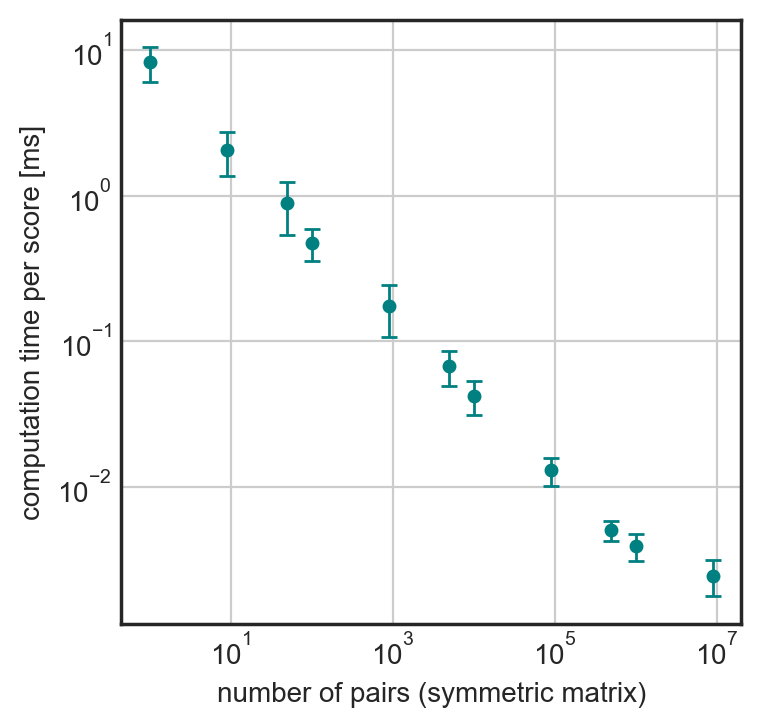

In [436]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4, 4), dpi=200)
plt.style.use('seaborn-white')
labels = np.array([1, 3, 7, 10, 30, 70, 100, 300, 700, 1000, 3000])**2
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(labels, iterations_scaled2.mean(axis=0),
             yerr=1 * iterations_scaled2.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of pairs (symmetric matrix)')
plt.yscale("log")
plt.xscale("log")
#plt.ylim(0)
plt.grid(True)
plt.savefig("spec2vec_performance_vs_num_pairs_synthetic_201202_200peaks.svg")

In [150]:
len(spectrums_processed), len(documents), similarity_matrix.shape

(1000, 10000, (10000, 10000))

In [146]:
#spectrums_processed = [s for s in spectrums_processed if s is not None]  

documents = [SpectrumDocument(s, n_decimals=2) for s in 10 * spectrums_processed]  

# Define similarity measure
spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage= 20.0)

#filename = os.path.join(path_data, f"similarities_spec2vec_tol0005_201128_max{max_peaks}.npy")

tstart = time.time()
similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=False)

tend = time.time()

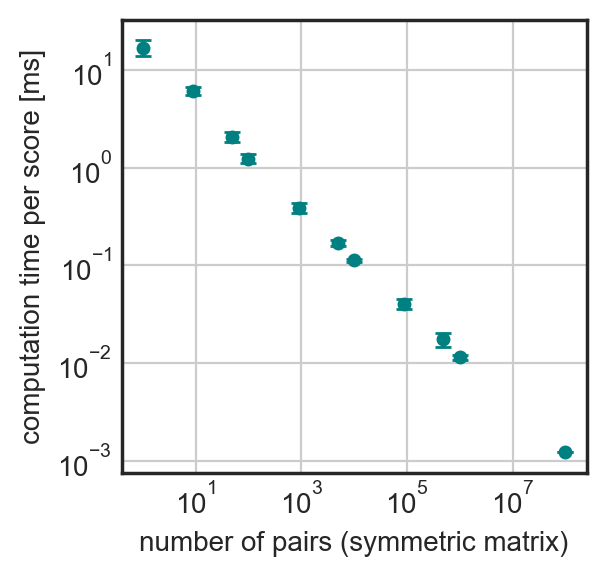

In [163]:
means = [x for x in iterations_scaled2.mean(axis=0)]
stds = [x for x in iterations_scaled2.std(axis=0)]
means.append(0.0012251)
stds.append(0)

from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = [x for x in np.array(n_spectrums)**2]
labels.append(10000**2)
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(labels, means,
             yerr=1 * stds, fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of pairs (symmetric matrix)')
plt.yscale("log")
plt.xscale("log")
#plt.ylim(0)
plt.grid(True)
#plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201.svg")

In [152]:
(tend - tstart)/10000**2 * 1000

0.001225095567703247

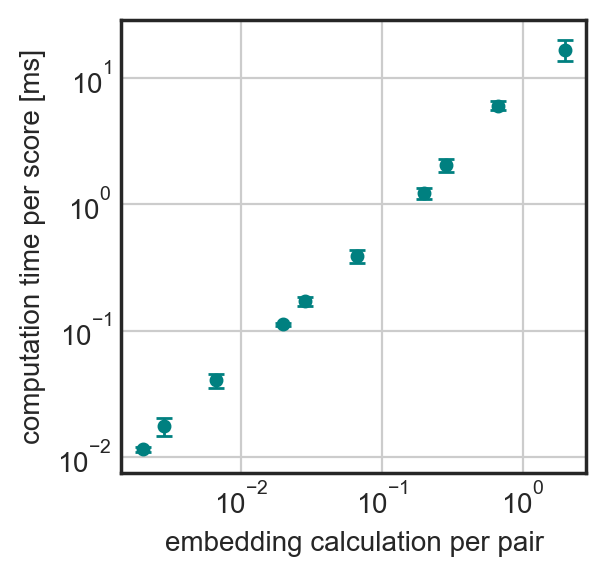

In [126]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = 2 * np.array(n_spectrums) / (np.array(n_spectrums)**2)
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(labels, iterations_scaled2.mean(axis=0),
             yerr=1 * iterations_scaled2.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('embedding calculation per pair')
plt.yscale("log")
plt.xscale("log")
#plt.ylim(0)
plt.grid(True)
#plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201.svg")

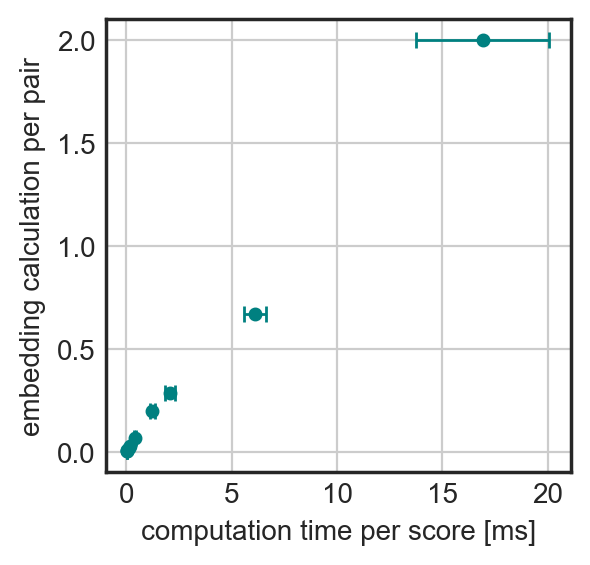

In [141]:
from matplotlib import pyplot as plt

plt.figure(figsize=(3,3), dpi=200)
plt.style.use('seaborn-white')
labels = 2 * np.array(n_spectrums) / (np.array(n_spectrums)**2)
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(iterations_scaled2.mean(axis=0), labels, 
             xerr=1 * iterations_scaled2.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.xlabel('computation time per score [ms]')
plt.ylabel('embedding calculation per pair')
#plt.yscale("log")
#plt.xscale("log")
#plt.ylim((0, 0.04))
#plt.xlim((0, 0.1))
plt.grid(True)
#plt.savefig("spec2vec_performance_vs_peaks_synthetic_201201.svg")

In [167]:
vectors.shape

(300, 1000)

# Limit will be computation time for cosine similarity between embeddings:

In [174]:
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix

embedding_dim = 300
n_vectors = 1000
vectors = np.random.rand(n_vectors, embedding_dim)

tstart = time.time()
scores = cosine_similarity_matrix(vectors, vectors)
tend = time.time()

print(tend - tstart)
print(scores.shape)
comp_time = 1000 * (tend - tstart) / n_vectors**2
print(f"Compuation time per score is {comp_time} ms")

0.5867679119110107
(1000, 1000)
Compuation time per score is 0.0005867679119110108 ms


In [450]:
max(n_embeddings)

1000

In [452]:
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix, cosine_similarity

n_embeddings = [1, 3, 7, 10, 30, 70, 100, 300, 700, 1000]
n_iterations = 10
#sub_loops = 1
#max_number_peaks = [50, 100, 200, 500, 750, 1000, 1500, 2000]
max_peaks = 500
    
iterations = []
sub_loops = []
for i in range(n_iterations):
    calculation_times = []

    print(f"Iteration {i + 1} -----------------")
    for n_vectors in n_embeddings:
        vectors = np.random.rand(n_vectors, embedding_dim)
        
        iters = int(np.floor(max(n_embeddings) ** 2 / n_vectors ** 2))
        sub_loops.append(iters)
        tstart = time.time()
        for _ in range(iters):
            #if n_vectors == 1:
            #    scores = cosine_similarity(vectors[0,:], vectors[0,:])
            #else:
            scores = cosine_similarity_matrix(vectors, vectors)
            assert scores.shape == (n_vectors, n_vectors)
        tend = time.time()
        
        print(f"Calculating cosine similarities for {n_vectors}x{n_vectors} embeddings took {tend - tstart:.1f} s.")
        calculation_times.append(tend - tstart)

    iterations.append(calculation_times)

Iteration 1 -----------------
Calculating cosine similarities for 1x1 embeddings took 2.2 s.
Calculating cosine similarities for 3x3 embeddings took 0.8 s.
Calculating cosine similarities for 7x7 embeddings took 0.6 s.
Calculating cosine similarities for 10x10 embeddings took 0.6 s.
Calculating cosine similarities for 30x30 embeddings took 0.6 s.
Calculating cosine similarities for 70x70 embeddings took 0.6 s.
Calculating cosine similarities for 100x100 embeddings took 0.6 s.
Calculating cosine similarities for 300x300 embeddings took 0.6 s.
Calculating cosine similarities for 700x700 embeddings took 0.6 s.
Calculating cosine similarities for 1000x1000 embeddings took 0.5 s.
Iteration 2 -----------------
Calculating cosine similarities for 1x1 embeddings took 2.1 s.
Calculating cosine similarities for 3x3 embeddings took 0.7 s.
Calculating cosine similarities for 7x7 embeddings took 0.6 s.
Calculating cosine similarities for 10x10 embeddings took 0.7 s.
Calculating cosine similarities 

In [456]:
np.array(sub_loops[:10])

array([1000000,  111111,   20408,   10000,    1111,     204,     100,
            11,       2,       1])

In [457]:
iterations_scaled = 1000 * np.array(iterations)/(np.array(sub_loops[:10]) * np.array(n_embeddings)**2)
iterations_scaled.mean(axis=0), iterations_scaled.std(axis=0)

(array([0.00248934, 0.00077019, 0.00058584, 0.00057642, 0.00055926,
        0.00057352, 0.0005722 , 0.00057551, 0.00061893, 0.00063125]),
 array([2.25246012e-04, 5.70769357e-05, 3.13826710e-05, 4.08665223e-05,
        3.00027204e-05, 5.04172633e-05, 3.60950642e-05, 3.89986303e-05,
        4.39708756e-05, 5.50361577e-05]))

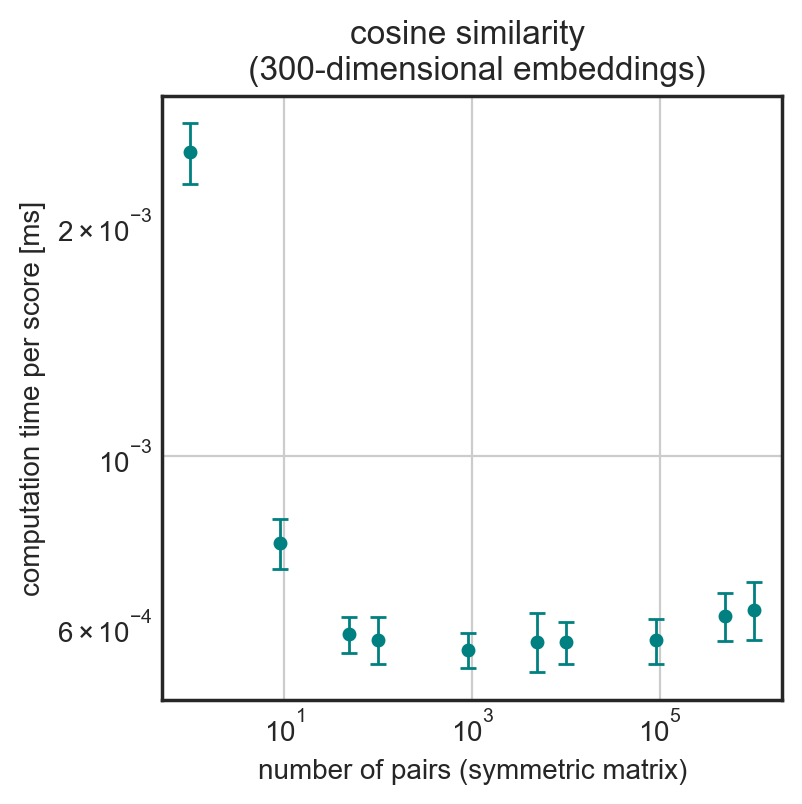

In [459]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4,4), dpi=200)
plt.style.use('seaborn-white')
labels = np.array(n_embeddings)**2
#plt.scatter(labels, np.array(iterations2)/np.array(n_spectrums)**2, s=25, color="red")

plt.errorbar(labels, iterations_scaled.mean(axis=0),
             yerr=1 * iterations_scaled.std(axis=0), fmt='o', ms=4,
             elinewidth=1, capsize=3, color="teal", ecolor="teal")
plt.ylabel('computation time per score [ms]')
plt.xlabel('number of pairs (symmetric matrix)')
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-4)
plt.grid(True)
plt.title("cosine similarity \n (300-dimensional embeddings)")
plt.savefig("cosine_similarity_performance_vs_num_pairs_synthetic_201201.svg")